# Extraction of weather data from Google Earth Engine

In [ ]:
!git clone https://github.com/AnujTiwari/India-State-and-Country-Shapefile-Updated-Jan-2020.git

Cloning into 'India-State-and-Country-Shapefile-Updated-Jan-2020'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 28 (delta 5), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (28/28), 16.46 MiB | 7.77 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [ ]:
import ee
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from shapely.geometry import mapping, shape
import time
import json
from tqdm import tqdm

In [ ]:
from google.colab import drive
ee.Authenticate()
drive.mount('/content/drive')
ee.Initialize(project="unibonn-419309")

Mounted at /content/drive


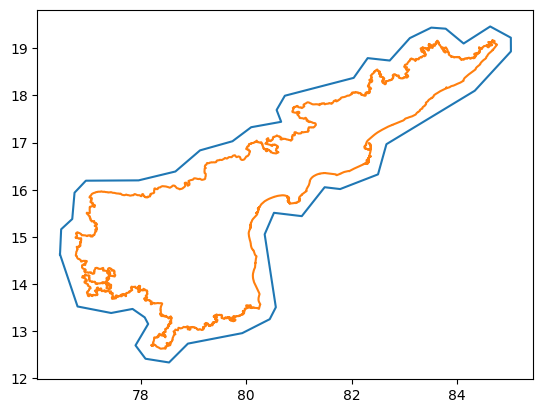

In [ ]:
crs = 4326

states = gpd.read_file("India-State-and-Country-Shapefile-Updated-Jan-2020/India_State_Boundary.shp")
states.to_crs(epsg=crs, inplace=True)

ap_geometry_orig = states.loc[states["State_Name"]
                         == "Andhra Pradesh"].geometry.iat[0]

ap_geometry = ap_geometry_orig.buffer(0.3).simplify(0.1)

fig, ax = plt.subplots(1)
ax.plot(ap_geometry.exterior.xy[0], ap_geometry.exterior.xy[1])
ax.plot(ap_geometry_orig.exterior.xy[0], ap_geometry_orig.exterior.xy[1])

In [ ]:
scale = 11132

roi = ee.Geometry(mapping(ap_geometry))

variables = [
    "dewpoint_temperature_2m",
    "temperature_2m",
    "surface_solar_radiation_downwards_sum",
    "total_evaporation_sum",
    "u_component_of_wind_10m",
    "v_component_of_wind_10m",
    "surface_pressure",
    "total_precipitation_sum",
    "leaf_area_index_high_vegetation",
    "leaf_area_index_low_vegetation",
]

grid = ee.FeatureCollection(roi.
                            coveringGrid(proj=roi.projection(),
                            scale=scale))

In [ ]:
dates = pd.date_range(start='2017-11-26', end='2024-01-10').strftime("%Y-%m-%d")

In [ ]:
previous_date = None

for i, date in tqdm(enumerate(dates)):
  gfs = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR")\
    .filterDate(date).map(lambda img:img.clip(roi))\
    .select(variables).first()

  res = gfs.reduceRegions(collection=grid, reducer=ee.Reducer.first(), scale=scale, crs=f'EPSG:{crs}')

  file_name = f"weather_{date}"
  task = ee.batch.Export.table.toDrive(
      collection=res,
      description=file_name,
      fileFormat="CSV",
      folder="ee"
  )
  task.start()

  while task.status()["state"] not in ["COMPLETED", "FAILED", "CANCELLED"]:
      time.sleep(3)
      #print(f"Task is: {task.status()['state']}")

  if previous_date is not None:
    previous_file_name = f"weather_{previous_date}"
    df = pd.read_csv(f"/content/drive/MyDrive/ee/{previous_file_name}.csv")
    df.rename(columns={"system:index": "cell_id"}, inplace=True)
    df.drop(columns=".geo", inplace=True)
    float32_df = df.astype({col: 'float32' for col in df.select_dtypes(include=['float64']).columns})
    float32_df.to_feather(f"/content/drive/MyDrive/ee/{previous_file_name}.feather")
    os.remove(f"/content/drive/MyDrive/ee/{previous_file_name}.csv")

  previous_date = dates[i-10] if i >= 10 else None

631it [2:04:06, 11.80s/it]


In [ ]:
for i, date in tqdm(enumerate(dates)):
  file_name = f"weather_{date}"
  csv_path = f"/content/drive/MyDrive/ee/{file_name}.csv"
  if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    df.rename(columns={"system:index": "cell_id"}, inplace=True)
    df.drop(columns=".geo", inplace=True)
    float32_df = df.astype({col: 'float32' for col in df.select_dtypes(include=['float64']).columns})
    float32_df.to_feather(f"/content/drive/MyDrive/ee/{file_name}.feather")
    os.remove(csv_path)

2237it [00:06, 325.76it/s] 


In [ ]:
for i, date in tqdm(enumerate(dates)):
  file_name = f"weather_{date}"
  feather_path = f"/content/drive/MyDrive/ee/{file_name}.feather"
  if not os.path.exists(feather_path):
    print(feather_path)

2237it [00:00, 6750.90it/s]


In [ ]:
reference_day = pd.Timestamp("2018-01-01")


def standardize_date(timestamps):
    if timestamps.tz:
        ref = reference_day.tz_localize(timestamps.tz)
    else:
        ref = reference_day
    return (timestamps-ref).days

In [ ]:
dates = pd.date_range(start='2017-11-26', end='2024-01-10')

In [ ]:
total_df = pd.DataFrame()
for i, date in tqdm(enumerate(dates)):
    date_str = date.strftime("%Y-%m-%d")
    file_name = f"weather_{date_str}"
    df = pd.read_feather(f"/content/drive/MyDrive/ee/{file_name}.feather")
    df["date"] = standardize_date(date)
    total_df = pd.concat([total_df, df])

2237it [23:17,  1.60it/s]


In [ ]:
total_df.reset_index().to_feather(f"/content/drive/MyDrive/ee/total.feather")

In [ ]:
!ls /content/drive/MyDrive/ee/weather_2018-04*

/content/drive/MyDrive/ee/weather_2018-04-01.feather
/content/drive/MyDrive/ee/weather_2018-04-02.feather
/content/drive/MyDrive/ee/weather_2018-04-03.feather
/content/drive/MyDrive/ee/weather_2018-04-04.feather
/content/drive/MyDrive/ee/weather_2018-04-05.feather
/content/drive/MyDrive/ee/weather_2018-04-06.feather
/content/drive/MyDrive/ee/weather_2018-04-07.feather
/content/drive/MyDrive/ee/weather_2018-04-08.feather
/content/drive/MyDrive/ee/weather_2018-04-09.feather
/content/drive/MyDrive/ee/weather_2018-04-10.feather
/content/drive/MyDrive/ee/weather_2018-04-11.feather
/content/drive/MyDrive/ee/weather_2018-04-12.feather
/content/drive/MyDrive/ee/weather_2018-04-13.feather
/content/drive/MyDrive/ee/weather_2018-04-14.feather
/content/drive/MyDrive/ee/weather_2018-04-15.feather
/content/drive/MyDrive/ee/weather_2018-04-16.feather
/content/drive/MyDrive/ee/weather_2018-04-17.feather
/content/drive/MyDrive/ee/weather_2018-04-18.feather
/content/drive/MyDrive/ee/weather_2018-04-19.f

## Write grid

In [ ]:
task = ee.batch.Export.table.toDrive(
    collection=grid,
    description='grid',
    fileFormat='CSV',
    folder='ee'
)
task.start()

while task.status()['state'] not in ['COMPLETED', 'FAILED', 'CANCELLED']:
    time.sleep(5)
    print(f'Task is: {task.status()["state"]}')

Task is: RUNNING
Task is: COMPLETED


In [ ]:
gdf = pd.read_csv("/content/drive/MyDrive/ee/grid.csv")
gdf['.geo'] = gdf['.geo'].apply(lambda x: shape(json.loads(x)))

In [ ]:
gdf.rename(columns={"system:index": "cell_id", ".geo":"geometry"}, inplace=True)
gdf = gpd.GeoDataFrame(gdf, geometry="geometry")
gdf.set_crs(crs, inplace=True)

,cell_id,geometry
0,"781,123","POLYGON ((78.10036 12.30006, 78.20036 12.30006..."
1,"782,123","POLYGON ((78.20036 12.30006, 78.30036 12.30006..."
2,"783,123","POLYGON ((78.30036 12.30006, 78.40036 12.30006..."
3,"784,123","POLYGON ((78.40036 12.30006, 78.50036 12.30006..."
4,"785,123","POLYGON ((78.50036 12.30006, 78.60036 12.30006..."
...,...,...
2386,"837,194","POLYGON ((83.70038 19.40009, 83.80038 19.40009..."
2387,"838,194","POLYGON ((83.80038 19.40009, 83.90038 19.40009..."
2388,"845,194","POLYGON ((84.50039 19.40009, 84.60039 19.40009..."
2389,"846,194","POLYGON ((84.60039 19.40009, 84.70039 19.40009..."


<Axes: >

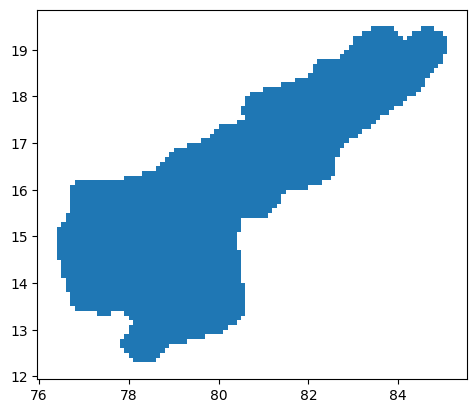

In [ ]:
gdf.plot()

In [ ]:
gdf.to_file('/content/drive/MyDrive/ee/grid.geojson', driver='GeoJSON')